In [37]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

NUM_CLASSES = 3
CHANNELS_D = 3
IMG_SIZE = 256
DATA_DIR = "/home/will/Documents/datasets/archive/caltech101_classification/"

device = "cuda" if torch.cuda.is_available() else "cpu"
classes = ["Motorcycle", "Airplane", "Schooner"]

Compute the mean and standard deviation of the images and use that to normalize them for training.

In [30]:
# for simplicity, just normalize whole dataset instead of each class label
def norm_transforms():
    transform = transforms.Compose(
        [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
    )
    dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
    # concat image data (CxWxH) in tensor, discard labels
    imgs = torch.stack([img_t for img_t, _ in dataset], dim=3)
    # flatten the three channels of all images and take the mean
    mean = np.array([m for m in imgs.view(3, -1).mean(dim=1)])
    std = np.array([s for s in imgs.view(3, -1).std(dim=1)])

    norm = transforms.Normalize(
        mean = mean,
        std = std
    )
    unnorm = transforms.Normalize(
        mean = -(mean/std),
        std = (1 / std)
    )
    
    return norm, unnorm
norm, unnorm = norm_transforms()

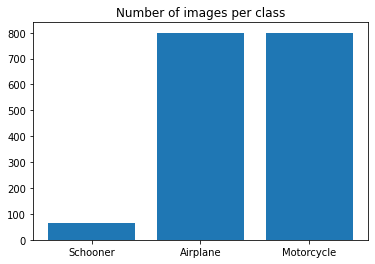

Class weights


0.962      Schooner
0.518      Airplane
0.520    Motorcycle
dtype: object

In [38]:
import pandas as pd

class_weights = []
total_len = 0
for _, _, files in os.walk(DATA_DIR):
    if len(files) > 0:
        class_weights.append(len(files))
    total_len += len(files)
plt.bar(classes[::-1], class_weights)
plt.title("Number of images per class")
plt.show()

class_weights = np.round((1 - np.array(class_weights) / total_len), 3)
class_weights = class_weights.tolist()

print("Class weights")
df = pd.Series(classes[::-1], class_weights)
class_weights = torch.tensor(class_weights)

df

In [39]:
def load_data():
    transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            norm,
        ]
    )
    dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size

    train_data, test_data = torch.utils.data.random_split(
        dataset, [train_size, test_size]
    )

    return train_data, test_data
    # train_data, test_val_data = torch.utils.data.random_split(
    #     dataset, [train_size, test_val_size]
    # )

    # val_size = int(0.5 * len(test_val_data))
    # test_size = len(test_val_data) - val_size
    # val_data, test_data = torch.utils.data.random_split(
    #     test_val_data, [val_size, test_size]
    # )
    # return train_data, val_data, test_data
    
# train_data, val_data, test_data = load_data()
train_data, val_data = load_data()

### My attempt at CNNs

In [40]:
class CNN(nn.Module):
    def __init__(self, num_layers, expansion):
        super().__init__()
        self.fcl, self.net = self._gen_layers(num_layers, expansion)
        self.classifier = self._classifier()
        
    def _gen_layers(self, num_layers, expansion):
        layers = []
        in_channels = CHANNELS_D
        
        for i in range(num_layers):
            out_channels = expansion(in_channels)
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
            ]
            layers += [nn.ReLU(), nn.BatchNorm2d(out_channels)]
            layers += [nn.MaxPool2d(2, 2)]
            in_channels = out_channels
        fcl = ((IMG_SIZE // (2 ** num_layers)) ** 2) * in_channels
        
        return fcl, nn.Sequential(*layers)

    def _classifier(self):
        layers = [
            nn.Flatten(1),
            nn.Linear(self.fcl, 256),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES)
        ]
        
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(self.net(x))

Create functions used for training and evaluating CNNs

In [41]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += pred.item() == label
        return correct, round((correct / len(data) * 100), 3)
        
def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Need to apply the weighted value to each class when computing loss to make up for dataset imbalence.

In [43]:
def train(model, train_data, val_data, batch, epochs, lr, class_weights):
    loader = DataLoader(
        train_data,
        batch_size=batch,
        shuffle=True,
        num_workers=2,
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.SGD(model.parameters(), lr=lr)

    epoch_data = []
    for epoch in range(epochs):
        running_loss, running_acc = 0.0, 0.0
        for i, (imgs, labels) in enumerate(loader):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            running_acc += torch.sum(pred == labels).item()

        model.eval()
        _, val_acc = eval(model, val_data)
        model.train()

        running_acc = round(running_acc / len(train_data) * 100, 3)
        running_loss /= len(loader)
        print(f'epoch: {epoch + 1} loss: {running_loss:.6f}')
        epoch_data.append(
            (epoch, float(f"{(running_loss):.6f}"), running_acc, val_acc)
        )
    
    return epoch_data

Test different amounts of convolutional layers

In [ ]:
expansions = []
lrs = [1e-4, 2e-3, 35e-4, 0.01]
num_layers = 4
batch_size = 128
num_epochs = 20

# recursive expressions to use for expanding feature map from conv layer
expansions.append(lambda x: x + 13)
expansions.append(lambda x: x*2 if x < 20 else x + (x // 2))
expansions.append(lambda x: x*3 if x < 50 else x + (x // 6))

runs = []
for n in range(num_layers):
    for expr in expansions:
        model = CNN(n + 1, expr).to(device)
        epoch_data = train(
            model,
            train_data,
            val_data,
            batch_size,
            num_epochs,
            lrs[n],
            class_weights
        )
        print("evaluating...")
        model.eval() # set eval for batch norm bc batch size is only 1
        n_params = count_params(model)
        runs.append((n, expr, n_params, epoch_data))
        del model

Plot performance metrics

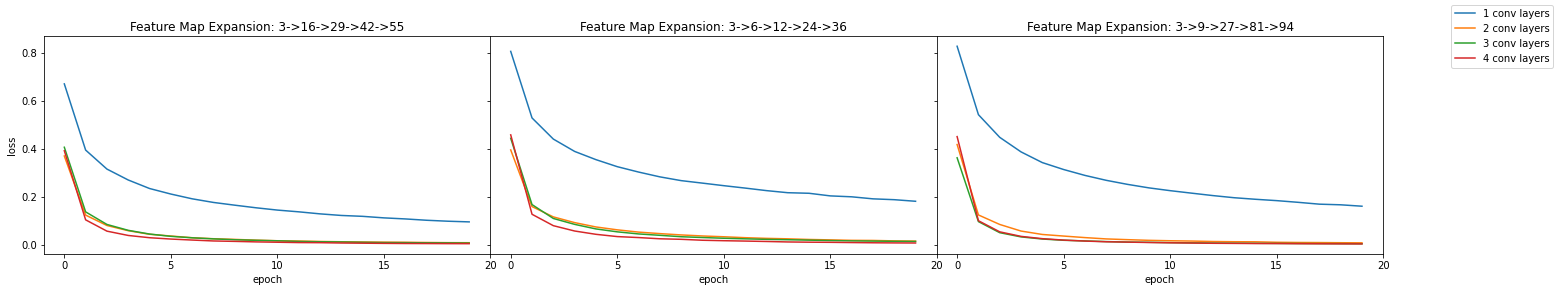

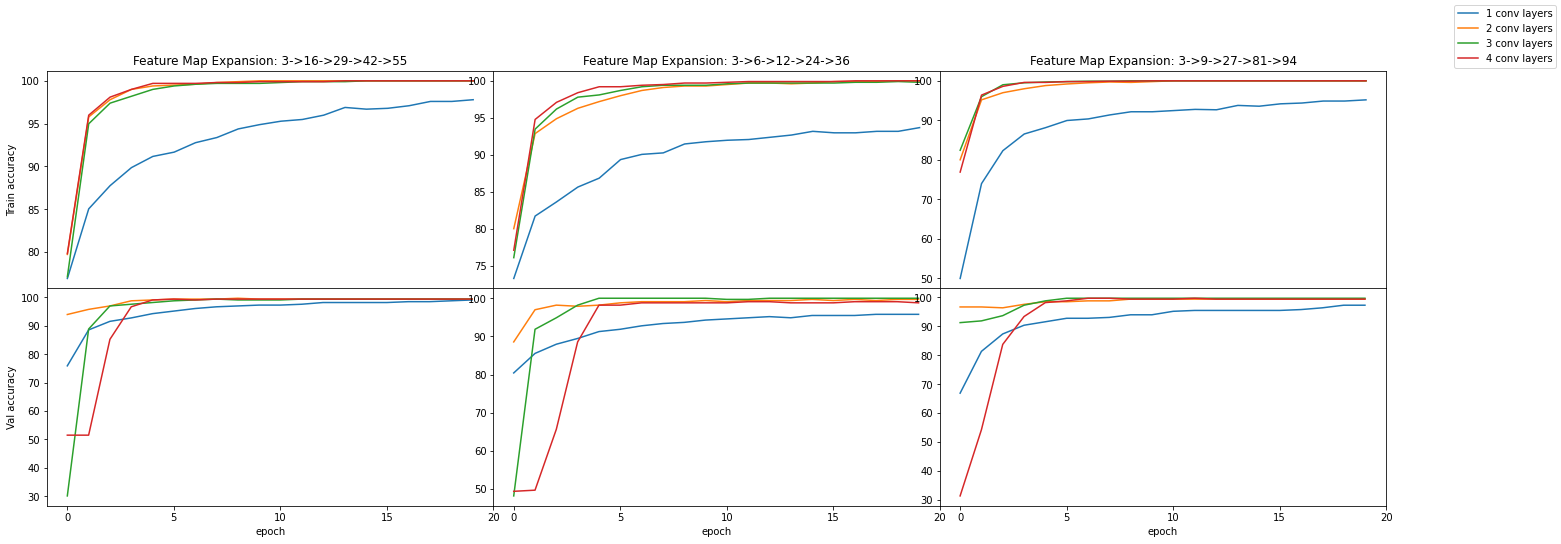

In [9]:
def str_conv_seq(expr, n_lay):
    prior = CHANNELS_D
    conv_seq = str(prior)
    total = 0
    for i in range(n_lay + 1):
        prior = expr(prior)
        total += prior
        conv_seq += f"->{str(prior)}"
    conv_seq
    return conv_seq, total

def plot_losses(runs):
    fig, axs = plt.subplots(1, len(expansions), figsize=(24,4),
        gridspec_kw={'wspace': 0}, sharey=True)

    axs[0].set(ylabel="loss")
    for (n_lay, expr, n_params, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq, _ = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]
        axs[c].set_title("Feature Map Expansion: " + conv_seq)
        if c == len(expansions) - 1:
            axs[c].plot(train_info[0], train_info[1], label=f"{n_lay + 1} conv layers")    
        else:
            axs[c].plot(train_info[0], train_info[1])

    for ax in axs:
        ax.set(xlabel="epoch")
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

def plot_accuracies(runs):
    fig, axs = plt.subplots(2, len(expansions), figsize=(24,8),
        gridspec_kw={'hspace': 0, 'wspace': 0})

    axs[0, 0].set(ylabel='Train accuracy')
    axs[1, 0].set(ylabel='Val accuracy')
    for (n_lay, expr, n_params, epoch_data) in runs:
        c = expansions.index(expr)
        conv_seq, _ = str_conv_seq(expr, n_lay)
        train_info = [*zip(*epoch_data)]

        if c == len(expansions) - 1:
            axs[0, c].plot(train_info[0], train_info[2], label=f"{n_lay + 1} conv layers") 
        else:
            axs[0, c].plot(train_info[0], train_info[2])
        
        axs[0, c].set_title("Feature Map Expansion: " + conv_seq)
        axs[1, c].plot(train_info[0], train_info[3])

    for ax in axs[1, :]:
        ax.set(xlabel="epoch")
        ax.set_xticks(np.arange(0, num_epochs + 1, 5))

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels)

  
plot_losses(runs)
plot_accuracies(runs)


In [10]:
def show_final_acc(runs):
    convs = []
    for (n_lay, expr, _, epoch_data) in runs:
        conv_seq, total = str_conv_seq(expr, n_lay)
        conv_seq += f" FM total: {total}"
        convs.append((f"{epoch_data[-1][-1]}%", conv_seq))
    df = pd.Series(*zip(*convs))
    print("accuracies on validation set")
    return df
        
show_final_acc(runs)

accuracies on validation set


3->16 FM total: 16                 99.096%
3->6 FM total: 6                   95.783%
3->9 FM total: 9                   97.289%
3->16->29 FM total: 45             99.398%
3->6->12 FM total: 18              99.699%
3->9->27 FM total: 36              99.398%
3->16->29->42 FM total: 87         99.398%
3->6->12->24 FM total: 42           100.0%
3->9->27->81 FM total: 117         99.699%
3->16->29->42->55 FM total: 142    99.398%
3->6->12->24->36 FM total: 78      98.795%
3->9->27->81->94 FM total: 211     99.398%
dtype: object

The way we expand each conv layer in terms of feature maps doesn't seem to influence the performance as much.
It appears to perform better the deeper the network gets. 

More methods of evaluating the performance of a model

In [88]:
def get_incorrect(model, data):
    with torch.no_grad():
        incorrect = []
        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            if pred.item() != label:
                incorrect.append((img, label, pred))
                
    return incorrect

def show_incorrect(incorrect):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 2, len(incorrect) // 2 + 1
    correct = 0

    for i, (img, label, pred_label) in enumerate(incorrect):
        figure.add_subplot(rows, cols, i + 1)
        img = unnorm(img).to("cpu")
        npimg = np.transpose(img.numpy(), (1, 2, 0))
        plt.title(f"actual: {classes[label]} pred: {classes[pred_label]}")
        plt.axis("off",)
        plt.imshow((npimg * 255).astype(np.uint8))

In [ ]:
def sample(model, test_data):
    with torch.no_grad():
        figure = plt.figure(figsize=(10, 8))
        cols, rows = 4, 4
        correct = 0

        for i in range(1, cols * rows + 1):
            rand = torch.randint(len(test_data), size=(1,)).item()
            img, label = test_data[rand]
            img_input = img.to(device).unsqueeze(0)

            figure.add_subplot(rows, cols, i)
            img = unnorm(img)
            npimg = np.transpose(img.numpy(), (1, 2, 0))

            plt.title(f"({i}) {classes[label]}")
            plt.axis("off",)
            plt.imshow((npimg * 255).astype(np.uint8))

            pred = model(img_input).to('cpu')

            _, pred = torch.max(pred.squeeze(), 0)
    
            print(f"({i}) Prediction: {classes[pred.item()]}, \
                Actual: {classes[label]}")
            correct += classes[pred.item()] == classes[label]
        
        print(f"\n {correct} / {cols * rows} correct -> \
            {correct / (cols * rows) * 100}%")
        plt.show()

In [ ]:
model.eval()
correct, acc = eval(model, val_data)
show_incorrect(get_incorrect(model, val_data))
print(f"{correct} out of {len(val_data)} correct \
    accuracy: {acc}%")


### VGGNet implementation

paper: https://arxiv.org/abs/1409.1556

![vgg_arch.png](./imgs/vgg_arch.png)

- Conv layers use 3x3 kernel with the exception of C
- C uses 1x1 kernel at the end of the last three sections 
- Padding used on convolutions to maintain dimensionality of input
- Maxpool between each section of conv layers uses 2x2 for kernel and stride
- Maxpool is followed by ReLU

`Added batch norm after a convolution to originial model architecture`

In [11]:
class VGG(nn.Module):
    def __init__(self, net_config=None):
        super().__init__()
        self.configs = {         # not including A-LRN for convenience
            'A': [1, 1, 2, 2, 2],
            'B': [2, 2, 2, 2, 2],
            'C': [2, 2, 3, 3, 3],
            'D': [2, 2, 3, 3, 3],
            'E': [2, 2, 4, 4, 4]
        }
        if net_config:
            self.fcl, self.net = self._gen_layers(net_config)
            self.classifier = self._classifier()

    def _gen_layers(self, net_config):
        layers = []
        num_layers = self.configs[net_config]
        in_channels, out_channels = CHANNELS_D, 64

        for i, n in enumerate(num_layers):
            for j in range(1, n + 1):
                c_trans = net_config == "C" and j == n and out_channels >= 256
                (kernel, pad) = (1, 0) if c_trans else (3, 1)
                layers.append(nn.Conv2d(
                        in_channels, out_channels, kernel, padding=pad
                    )
                )
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                in_channels = out_channels
            layers.append(nn.MaxPool2d(2, 2))
            if out_channels < 512:
                out_channels *= 2
        fcl = ((IMG_SIZE // (2 ** 5)) ** 2) * in_channels

        return fcl, nn.Sequential(*layers)

    def _classifier(self):
        layers = []
        layers += [
            nn.Flatten(1),
            nn.Linear(self.fcl, 4096), nn.ReLU(),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Linear(4096, NUM_CLASSES)
        ]

        return nn.Sequential(*layers)
        
    def forward(self, x):
        return self.classifier(self.net(x))

In [12]:
runs_vgg = []
batch_size = 16
num_epochs = 30
lr = 1e-3

for (vgg_arch, layers) in VGG().configs.items():
    model = VGG(vgg_arch).to(device)
    epoch_data = train(
        model,
        train_data,
        val_data,
        batch_size,
        num_epochs,
        lr,
        class_weights
    )
    print("evaluating...")
    model.eval()
    _, accuracy = eval(model, val_data)
    runs_vgg.append((
        "VGG-" + str(np.sum(layers)) + vgg_arch,
        n_params,
        epoch_data
    ))
    del model

epoch: 1 loss: 0.492728
epoch: 2 loss: 0.224393
epoch: 3 loss: 0.150659
epoch: 4 loss: 0.104210
epoch: 5 loss: 0.085065
epoch: 6 loss: 0.068371
epoch: 7 loss: 0.054230
epoch: 8 loss: 0.040199
epoch: 9 loss: 0.040220
epoch: 10 loss: 0.031915
epoch: 11 loss: 0.029827
epoch: 12 loss: 0.022957
epoch: 13 loss: 0.022040
epoch: 14 loss: 0.018551
epoch: 15 loss: 0.020960
epoch: 16 loss: 0.015819
epoch: 17 loss: 0.012848
epoch: 18 loss: 0.013340
epoch: 19 loss: 0.011600
epoch: 20 loss: 0.011242
epoch: 21 loss: 0.010827
epoch: 22 loss: 0.008569
epoch: 23 loss: 0.007816
epoch: 24 loss: 0.007770
epoch: 25 loss: 0.006602
epoch: 26 loss: 0.006951
epoch: 27 loss: 0.005525
epoch: 28 loss: 0.005949
epoch: 29 loss: 0.008161
epoch: 30 loss: 0.006061
evaluating...
epoch: 1 loss: 0.512512
epoch: 2 loss: 0.244002
epoch: 3 loss: 0.148707
epoch: 4 loss: 0.099849
epoch: 5 loss: 0.075285
epoch: 6 loss: 0.064354
epoch: 7 loss: 0.050286
epoch: 8 loss: 0.043018
epoch: 9 loss: 0.036312
epoch: 10 loss: 0.032198
epoc

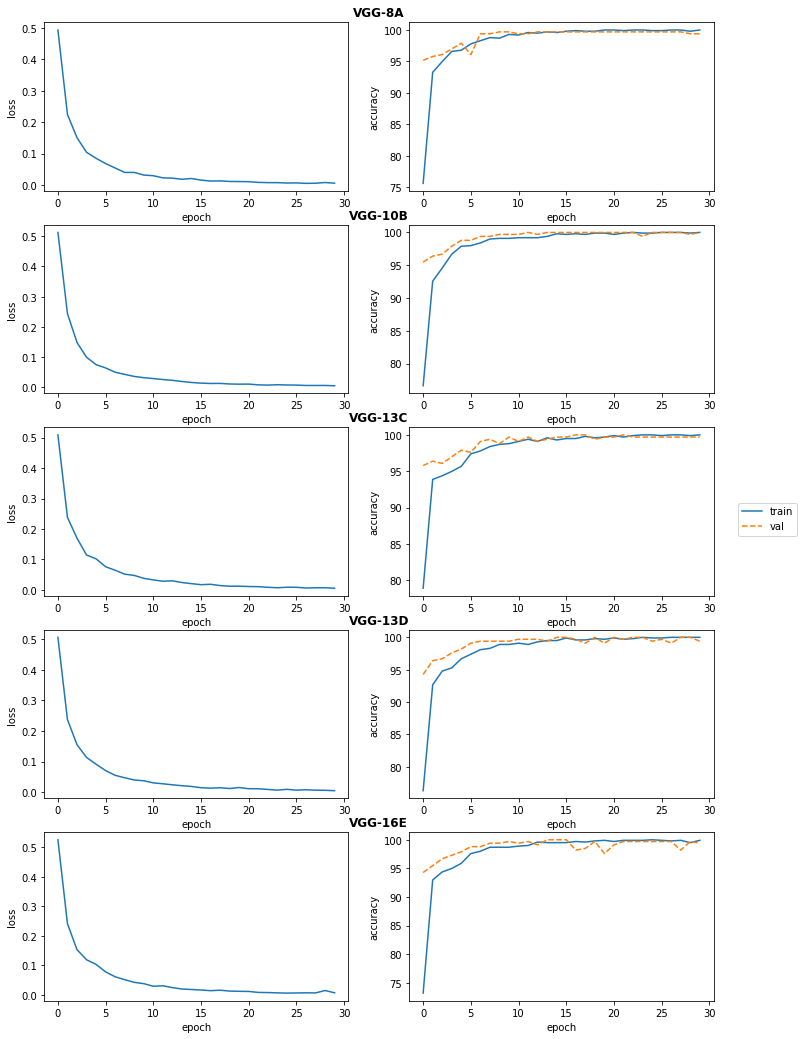

In [13]:
def subtitle(fig, grid, title):
    row = fig.add_subplot(grid)
    row.set_title(f'{title}', fontweight='semibold')
    row.set_frame_on(False)
    row.axis('off')

def plot_runs(runs):
    fig, axs = plt.subplots(len(runs), 2, figsize=(12,18))
    grid = plt.GridSpec(len(runs), 2)

    for i, (label, accuracy, epoch_data) in enumerate(runs):
        train_info = [*zip(*epoch_data)]
        axs[i, 0].set(ylabel="loss")
        axs[i, 1].set(ylabel="accuracy")
        axs[i, 0].plot(train_info[0], train_info[1], label=label)
        axs[i, 1].plot(train_info[0], train_info[2], label="train")
        axs[i, 1].plot(
            train_info[0], train_info[3], linestyle="dashed", label="val"
        )
        subtitle(fig, grid[i, ::], label)

    for ax in axs:
        ax[0].set(ylabel="loss")
        ax[1].set(ylabel="accuracy")
        ax[0].set(xlabel="epoch")
        ax[1].set(xlabel="epoch")

    lines_labels = [ax.get_legend_handles_labels() for ax in axs[0][1:]]
    lines, labels = [sum(l_l, []) for l_l in zip(*lines_labels)]
    fig.legend(lines, labels, loc='center right')
    plt.show()

plot_runs(runs_vgg)

In [14]:
def show_final_acc(runs):
    convs = []
    for (arch, n_params, epoch_data) in runs:
        convs.append((f"{epoch_data[-1][-1]}%", arch))
    df = pd.Series(*zip(*convs))
    print("accuracies on validation set")
    return df
        
show_final_acc(runs_vgg)

accuracies on validation set


VGG-8A     99.398%
VGG-10B     100.0%
VGG-13C    99.699%
VGG-13D    99.398%
VGG-16E    99.398%
dtype: object

### GoogLeNet implementation

paper: https://arxiv.org/abs/1409.4842.pdf

`Architecture`

![google_arch.png](./imgs/google_arch.png)

`Inception block`

![inception_block.png](./imgs/inception_block.png)

- Note: Model had softmax output layer

`Added batch norm after convolution to original model architecture`

In [15]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv  = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [16]:
class Inception(nn.Module):
    def __init__(self, in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool):
        super().__init__()
        self.inc_block = self._gen_branches(
            in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool
        )

    def _gen_branches(self, in_channels, _1x1, _3x3r, _3x3, _5x5r, _5x5, pool):
        b1 = nn.Sequential(Conv(in_channels, _1x1, kernel_size=1).to(device))
        b2 = nn.Sequential(
            Conv(in_channels, _3x3r, kernel_size=1).to(device),
            Conv(_3x3r, _3x3, kernel_size=3, padding=1).to(device)
        )
        b3 = nn.Sequential(
            Conv(in_channels, _5x5r, kernel_size=1).to(device),
            Conv(_5x5r, _5x5, kernel_size=5, padding=2).to(device)
        )
        b4 = nn.Sequential(
            nn.MaxPool2d(3, 1, 1),
            Conv(in_channels, pool, kernel_size=1).to(device)
        )

        return [b1, b2, b3, b4]

    def forward(self, x):
        return torch.cat([b(x) for b in self.inc_block], dim=1)

In [17]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = self._gen_layers()
        self.classifier = self._classifier()

    def _gen_layers(self):
        layers = [
            Conv(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, 1),
            Conv(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(3, 2, 1),
            Inception(192, 64, 96, 128, 16, 32, 32),
            Inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1),
            Inception(480, 192, 96, 208, 16, 48, 64),
            Inception(512, 160, 112, 224, 24, 64, 64),
            Inception(512, 128, 128, 256, 24, 64, 64),
            Inception(512, 112, 144, 288, 32, 64, 64),
            Inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, 1),
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 192, 384, 48, 128, 128),
        ]

        return nn.Sequential(*layers)

    def _classifier(self):
        feature_map_dim = IMG_SIZE // (2 ** 5)
        layers = [
            nn.AvgPool2d(feature_map_dim, 1),
            nn.Flatten(1),
            nn.Dropout(0.4),
            nn.Linear(1024, NUM_CLASSES)
        ]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = self.classifier(x)
        
        return x


In [44]:
runs_google = []
batch_size = 64
num_epochs = 50
lr = 1e-3

model = GoogLeNet().to(device)
epoch_data = train(
        model,
        train_data,
        val_data,
        batch_size,
        num_epochs,
        lr,
        class_weights
    )
print("evaluating...")
model.eval()
n_params = count_params(model)
runs_google.append(("GoogLeNet", n_params, epoch_data))
del model

epoch: 1 loss: 0.859077
epoch: 2 loss: 0.713672
epoch: 3 loss: 0.648980
epoch: 4 loss: 0.622198
epoch: 5 loss: 0.577638
epoch: 6 loss: 0.552261
epoch: 7 loss: 0.536470
epoch: 8 loss: 0.523578
epoch: 9 loss: 0.492867
epoch: 10 loss: 0.491465
epoch: 11 loss: 0.469750
epoch: 12 loss: 0.443088
epoch: 13 loss: 0.441899
epoch: 14 loss: 0.430143
epoch: 15 loss: 0.419594
epoch: 16 loss: 0.413054
epoch: 17 loss: 0.407464
epoch: 18 loss: 0.391899
epoch: 19 loss: 0.384915
epoch: 20 loss: 0.373365
epoch: 21 loss: 0.357464
epoch: 22 loss: 0.358904


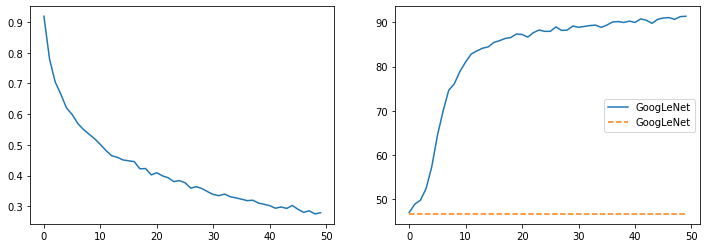

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

for (label, n_params, epoch_data) in runs_google:
    train_info = [*zip(*epoch_data)]
    axs[0].plot(train_info[0], train_info[1], label=label)
    axs[1].plot(train_info[0], train_info[2], label=label)
    axs[1].plot(train_info[0], train_info[3], label=label, linestyle="dashed")
plt.legend()
plt.show()

# print(runs_google[0][1])
# for (label, n_params, epoch_data) in runs_google:
#     train_info = [*zip(*epoch_data)]
#     print(train_info[3])


### Overall evaluation

### Conclusion